In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy, patsy, pickle

In [83]:
# data = pd.read_csv("data/tidy_normalize_all.csv",index_col=None)
data = pd.read_csv("data/tidy_normalize_log_st0.csv",index_col=None)
data = data[data.standard==1]

In [84]:
skip_strains = ['ura3_EV', u'cspD1_EV', u'cspD1_cspD1','ura3']

In [85]:
g = data.groupby('Strain')

In [86]:
ura3 = g.get_group('ura3')
g_ura3 = ura3.groupby(['Experiment','Well'])

In [7]:
def plot_model(x,gp,strain):
    time = np.linspace(0,43)
    
    plt.subplot(121)
    
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':['ura3']*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='k')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),color='k',alpha=.2)
    
    plt.subplot(122)
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':[strain]*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='g')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),alpha=.2,color='g')

In [8]:
def plot_data(data,strain):
    g = data.groupby("Strain")

    temp = g.get_group('ura3')
    g2 = temp.groupby(['Experiment','Well'])

    ylim = (np.round(data.OD.min() - .5,1),np.round(data.OD.max() + .5,1))

    plt.subplot(121)
    for ind,x in g2:
        x.sort_values('time',inplace=True)
        #plt.plot(x.time,patsy.build_design_matrices([y.design_info],x)[0],'k',alpha=.3)
        plt.plot(x.time,x.OD,'k',alpha=.1)
    plt.ylabel("log(OD)",fontsize=30)
    plt.xlabel("time (h)",fontsize=30)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.grid(True,color='grey')
    plt.xlim(-2,44)
    plt.ylim(ylim)

    temp = g.get_group(strain)
    g2 = temp.groupby(['Experiment','Well'])

    plt.subplot(122)
    for ind,x in g2:
        x.sort_values('time',inplace=True)
        #plt.plot(x.time,patsy.build_design_matrices([y.design_info],x)[0],'g',alpha=.3)
        plt.plot(x.time,x.OD,'g',alpha=.1)

    plt.xlabel("time (h)",fontsize=30)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.grid(True,color='grey')
    plt.xlim(-2,44)
    plt.ylim(ylim)

In [9]:
ind = ['strain','BF','BF-permuted']
table = pd.DataFrame(columns=ind)

In [215]:
import utils
reload(utils)

import plot
reload(plot)

<module 'plot' from 'plot.pyc'>

In [216]:
permutations = False # should we calculate the permutations?
save = False # should we save results?
_pickle = False
_plot = True
delta = True

od_delta = {}
od_delta_deriv = {}

for strain,temp in g:
    
    if strain in skip_strains:
        continue
        
    row = pd.Series(index=ind)
    row['strain'] = strain
    
    # add parent strain data
    temp_full = temp.append(ura3)
    
    select = temp_full.time.isin(np.arange(0,43,8))
    temp = temp_full[select]

    y,x = patsy.dmatrices('OD ~ scale(time) + C(Strain)',temp)
    
    print strain,temp.shape, temp.time.unique().shape
    
    gp = GPy.models.GPRegression(x[:,1:],y,GPy.kern.RBF(2,ARD=True))
    gp.optimize()
    
    if _plot:
        plt.figure(figsize=(12,6))
        plot_model(x,gp,strain)
        plot_data(temp_full,strain)
        plt.savefig("figures/standard/%s.png"%strain,bbox_inches="tight",dpi=300)    
        plt.close()
    
    gp_null = GPy.models.GPRegression(x[:,2][:,None],y,GPy.kern.RBF(1,ARD=True))
    gp_null.optimize()
    
    row.BF = gp.log_likelihood() - gp_null.log_likelihood()
    
    if _pickle:
        pickle.dump(gp,open('pickle/standard/%s.gp.pickle'%strain,'w'))
        
    if delta:
    
        mu,var = utils.compute_delta(gp,x,{'time':np.linspace(0,43)},{'Strain':[strain]*50},{'Strain':['ura3']*50})
        plt.figure(figsize=(12,6))
        plot.plot_mvn(mu,var)
        plt.title("$\Delta$ log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
        plt.xlim(-2,45)
        plt.savefig("figures/standard/od_delta/%s.png"%strain,bbox_inches="tight")
        plt.close()
        od_delta[strain] = (mu,var)

        mu,var = utils.compute_delta(gp,x,\
                                     {'time':np.linspace(0,43)},{'Strain':[strain]*50},{'Strain':['ura3']*50},\
                                     derivative=True,derivative_ind=1)
        plt.figure(figsize=(12,6))
        plot.plot_mvn(mu,var)
        plt.title("$\Delta$ d log(OD) / dt",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
        plt.xlim(-2,45)
        plt.savefig("figures/standard/od_delta_deriv/%s.png"%strain,bbox_inches="tight")
        plt.close()
        od_delta_deriv[strain] = (mu,var)
    
    del gp
    
    if permutations:
    
        perms = []
        for i in range(50):
            if i%10 == 0:
                print i

            x[:,1] = np.random.choice(x[:,1],x.shape[0],replace=False)
            gp = GPy.models.GPRegression(x[:,1:],y,GPy.kern.RBF(2,ARD=True))
            gp.optimize()

            perms.append(gp.log_likelihood() - gp_null.log_likelihood())

            del gp

        row['BF-permuted'] = perms
    
    del gp_null

    if save:
        table = table.append(row,ignore_index=True)
        table.index = range(table.shape[0])
        table.to_csv("standard_bfs.csv",index=False)
    

VNG0039 (1080, 12) (6,)


 /home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


VNG0194H (1080, 12) (6,)
VNG0471 (1080, 12) (6,)
VNG1029 (1080, 12) (6,)
VNG2268 (1080, 12) (6,)
VNG2614 (1080, 12) (6,)
arcR (1080, 12) (6,)
asnC (1080, 12) (6,)
birA (1080, 12) (6,)
copR (1152, 12) (6,)
cspD1 (1080, 12) (6,)
cspD2 (1080, 12) (6,)
hlx1 (1152, 12) (6,)
hlx2 (1080, 12) (6,)
hrg (1080, 12) (6,)
idr1 (1080, 12) (6,)
idr2 (1080, 12) (6,)
kaiC (1080, 12) (6,)
phoU (1080, 12) (6,)
prp2 (1080, 12) (6,)
rosR (1080, 12) (6,)
sirR (1080, 12) (6,)
trh2 (1080, 12) (6,)
trh3 (1080, 12) (6,)
trh4 (1080, 12) (6,)
trmB (1080, 12) (6,)
troR (1080, 12) (6,)


In [227]:
reload(plot)

plt.figure(figsize=(16,10))
plot.plot_delta(np.linspace(0,43),od_delta_deriv,mean=False,probability=True,cluster=True,cluster_kwargs={"method":'complete'})
plt.yticks(fontsize=15)
plt.savefig("figures/standard/od_delta_deriv_prob.png",bbox_inches="tight")
plt.close()


plt.figure(figsize=(16,10))
plot.plot_delta(np.linspace(0,43),od_delta_deriv,mean=True,probability=True,cluster=True,cluster_kwargs={"method":'complete'})
plt.yticks(fontsize=15)
plt.savefig("figures/standard/od_delta_deriv_mu.png",bbox_inches="tight")
plt.close()


plt.figure(figsize=(16,10))
plot.plot_delta(np.linspace(0,43),od_delta,mean=False,probability=True,cluster=True,cluster_kwargs={"method":'complete'})
plt.yticks(fontsize=15)
plt.savefig("figures/standard/od_delta_prob.png",bbox_inches="tight")
plt.close()


plt.figure(figsize=(16,10))
plot.plot_delta(np.linspace(0,43),od_delta,mean=True,probability=True,cluster=True,cluster_kwargs={"method":'complete'})
plt.yticks(fontsize=15)
plt.savefig("figures/standard/od_delta_mu.png",bbox_inches="tight")
plt.close()

 plot.py:45: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


In [224]:
x

DesignMatrix with shape (1080, 3)
  Intercept  C(Strain)[T.ura3]  scale(time)
          1                  0     -1.46385
          1                  0     -0.87831
          1                  0     -0.29277
          1                  0      0.29277
          1                  0      0.87831
          1                  0      1.46385
          1                  0     -1.46385
          1                  0     -0.87831
          1                  0     -0.29277
          1                  0      0.29277
          1                  0      0.87831
          1                  0      1.46385
          1                  0     -1.46385
          1                  0     -0.87831
          1                  0     -0.29277
          1                  0      0.29277
          1                  0      0.87831
          1                  0      1.46385
          1                  0     -1.46385
          1                  0     -0.87831
          1                  0     -0.2927

In [226]:
x.design_info.column_names

['Intercept', 'C(Strain)[T.ura3]', 'scale(time)']

In [12]:
table = pd.read_csv("standard_bfs.csv")

newtable = pd.DataFrame()
for i,r in table.iterrows():
    row = pd.Series()
    row['strain'] = r.strain
    row['BF'] = r.BF
    row['BF-permuted'] = eval(r['BF-permuted'])
    newtable = newtable.append(row,ignore_index=True)
    newtable.index = range(newtable.shape[0])
    
table = newtable[['strain','BF','BF-permuted']]
table.head()

,strain,BF,BF-permuted
0,VNG0039,12.446042,"[-2.14253559534e-05, -3.62749710803e-06, 1.192..."
1,VNG0194H,74.149553,"[0.562196768541, -9.85112569651e-06, -0.002145..."
2,VNG0471,18.190588,"[-4.62679345219e-05, -2.88162425477e-06, -7.99..."
3,VNG1029,22.009745,"[0.165506603674, -8.95853622751e-06, -5.329128..."
4,VNG2268,21.675561,"[-0.00125238457429, 0.126986397657, 1.34364972..."


In [17]:
for i,r in table.iterrows():
    print r.strain,r.BF,np.max(r['BF-permuted']),sum(r.BF<np.array(r['BF-permuted']))

VNG0039 12.4460415303 9.16726790407 0
VNG0194H 74.1495529679 0.562196768541 0
VNG0471 18.1905876761 1.87032366066 0
VNG1029 22.0097445524 4.07867423415 0
VNG2268 21.6755609062 1.5920855391 0
VNG2614 104.527843839 2.54554358423 0
arcR 50.5698315104 2.8580837795 0
asnC 85.2308545003 4.61728161936 0
birA 92.6928503378 2.6444348446 0
copR 50.0462425712 3.54607275705 0
cspD1 253.864886044 3.47564595799 0
cspD2 94.0652749119 1.05227034746 0
hlx1 97.4254490801 1.7550269512 0
hlx2 13.3597998537 3.43497044912 0
hrg -3.34904927968e-06 2.92359512931 25
idr1 49.1882520119 2.02198060126 0
idr2 222.229792405 1.00319192474 0
kaiC 10.7841131265 2.51899114292 0
phoU 106.766485543 1.35080731244 0
prp2 73.6289840902 1.11939102816 0
rosR 52.1614359725 2.14507653443 0
sirR 7.03242069535 4.23651681445 0
trh2 2.60201355899 2.34510079263 0
trh3 6.55745270763 2.9796133661 0
trh4 6.97103372198 2.27057933462 0
trmB 769.644402065 0.784916678191 0
troR 454.904789782 5.29090470279 0


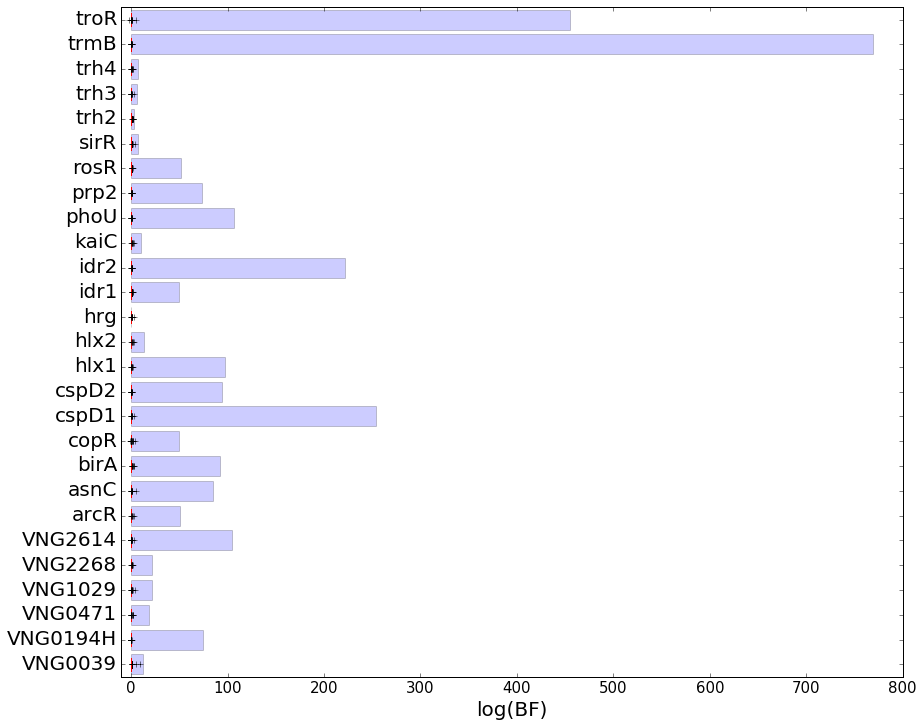

In [23]:
plt.figure(figsize=(14,12))

plt.barh(range(table.shape[0]),table.BF,alpha=.2)
plt.boxplot([p for p in table['BF-permuted']],positions=np.arange(.4,table.shape[0]+.4,1),vert=False);
plt.yticks(np.arange(table.shape[0])+.4,table.strain, fontsize=20);
plt.xlabel("log(BF)",fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(-10,800)

plt.savefig("figures/standard/bayesFactors.png",bbox_inches="tight")

In [125]:
[p for p in table['BF-permuted']]

[[-2.1425355953397229e-05,
  -3.6274971080274554e-06,
  1.1922384426019335,
  0.57533949013122765,
  0.45470543331862245,
  -0.0075441140897964942,
  0.53658230259998163,
  0.8313302072120905,
  4.6930415775423171,
  1.2235713125734264,
  -0.0010633575205929446,
  1.2333803138219537,
  -7.734001428616466e-06,
  -0.0013344701156938754,
  -5.7803474305728741e-05,
  -0.00017034703773788351,
  -2.5664900476840558e-05,
  -0.00014679946912110609,
  -5.2636383998105885e-06,
  -2.5115067955994164e-05,
  0.038450260378908752,
  -0.0003517237087180547,
  0.11484354931371854,
  0.0060360834322636947,
  -0.00020610074420801539,
  0.3377286417473897,
  0.12161448807592024,
  -0.0010074586575683497,
  -4.394324832901475e-06,
  0.23143328392234253,
  -3.0118590075289831e-06,
  0.95717429338765214,
  -5.6030942232609959e-06,
  0.014542947524432748,
  -1.281648280837544e-05,
  0.35002317640135061,
  0.021756825343572928,
  -0.00019222359014747781,
  -7.6273877994026407e-05,
  0.24163625523783594,
  -3.